# Test API

To test the API submission process

In [1]:
import traceback
import numpy as np
import pandas as pd
#import datatable as dt
import gc
import time
import os
import xgboost as xgb
import talib as ta
from script.crypto_API import *

## Model Version

In [2]:
ASSET_DETAILS_CSV = './data/asset_details.csv'
df_asset_details = pd.read_csv(ASSET_DETAILS_CSV).sort_values("Asset_ID")

version = 46
retrained = True #set to False to get correct out-train score
pre_minute=180 #psets['adx']*2+1 #for smoothing sensitive indicators
if version < 46:    
    if retrained:
        MOD_FOLDER = "./trainedXGB/retrained" + f"/model_nof_{version}_sub_sub"
    else:
        MOD_FOLDER = "./trainedXGB" + f"/model_nof_{version}"
else:
    MOD_FOLDER = "./trainedXGB" + f"/model_nof_{version}"

MOD_FOLDER

'./trainedXGB/model_nof_46'

model from ./trainedXGB/model_nof_46


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

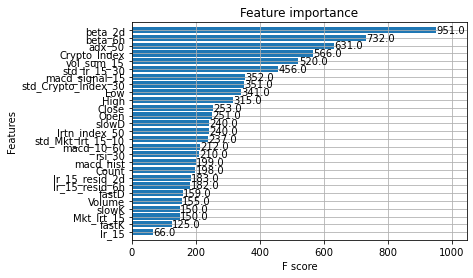

In [3]:
from os.path import exists
def model_reload_train():
    print(f"model from {MOD_FOLDER}")
    models = {}
    for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
        if version <46:
            model_file = MOD_FOLDER + f"/model_{asset_id}.json"
        elif retrained:
            model_file = MOD_FOLDER + f"/model_{asset_id}_alldata.json"
        else:
            model_file = MOD_FOLDER + f"/model_{asset_id}.json"

        if exists(model_file):
            model = xgb.Booster()
            model.load_model(model_file)
            models[asset_id] = model
    return models

models = model_reload_train()
xgb.plot_importance(models[1],height=0.8)

## get_features

In [4]:
# psets34 = dict(zip(['lrtn','fastk1','fastk2','adx','macd_s','macd_l','rsi','std_Crypto_Index','std_lr_15','std_Mkt_lrt_15'],
#                    [15, 15, 5, 30, 5, 25, 60, 5, 15, 30]))
      
import pickle
with open(MOD_FOLDER+f"/feature_best{version}", "rb") as f:
    psets=pickle.load(f)
    
if version < 44:
    psets['vol_sum'] = 0

psets

{'std_lr_15': 30,
 'std_Mkt_lrt_15': 10,
 'std_Crypto_Index': 30,
 'rsi': 30,
 'adx': 50,
 'macd_sig': 15,
 'macd_s': 10,
 'macd_l': 60,
 'lrtn': 50,
 'fastk2': 10,
 'fastk1': 15,
 'beta_s': '6h',
 'beta_l': '2d',
 'vol_sum': 15}

In [5]:
def log_return(series, periods=5):
    return np.log(series).diff(periods)


def lag_features(df, fastk1,fastk2,adx,macd_s,macd_l,macd_sig,rsi,vol_sum,std_Crypto_Index,std_lr_15,std_Mkt_lrt_15, **kwargs):    
    if vol_sum >0 :
        df[f'vol_sum_{vol_sum}'] = ta.SMA(df['Volume'],vol_sum)*vol_sum
    ####TECH indicators
    df['slowK'], df['slowD'] = ta.STOCH(df.High, df.Low, df.Close, 
                                        fastk_period=fastk1, slowk_period=int(3*fastk1/5), slowd_period=int(3*fastk1/5),
                                        slowk_matype=0, slowd_matype=0)
    df['fastK'], df['fastD'] = ta.STOCHF(df.High, df.Low, df.Close,
                                         fastk_period=fastk2, fastd_period=int(3*fastk2/5), 
                                         fastd_matype=0)
    df[f'macd_{macd_s}_{macd_l}'],df[f'macd_signal_{macd_sig}'], df['macd_hist'] = \
                ta.MACD(df['Close'],fastperiod=macd_s, slowperiod=macd_l, signalperiod=macd_sig)
    ##smoothing sensitive ADX 150, RSI250, AD unKNOWN
    df[f'rsi_{rsi}'] = ta.RSI(df['Close'], timeperiod=rsi)
    df[f'adx_{adx}'] = ta.ADX(df['High'], df['Low'],df['Close'], timeperiod=adx)
    df['AD'] = ta.AD(df['High'], df['Low'],df['Close'], df['Volume'])

    ####std volatility
    df[f'std_lr_15_{std_lr_15}'] = ta.STDDEV(df.lr_15,timeperiod=std_lr_15, nbdev=1)
    df[f'std_Mkt_lrt_15_{std_Mkt_lrt_15}'] = ta.STDDEV(df.Mkt_lrt_15,timeperiod=std_Mkt_lrt_15, nbdev=1)
    df[f'std_Crypto_Index_{std_Crypto_Index}'] = ta.STDDEV(df.Crypto_Index,timeperiod=std_Crypto_Index, nbdev=1)


def beta_resid(df, width): 
    b = ((ta.MULT(df.Mkt_lrt_15,df.lr_15).mean())/ \
        (ta.MULT(df.Mkt_lrt_15,df.Mkt_lrt_15).mean()))
    if b in [np.nan,np.inf,-np.inf]:
        b=0
    return b 

def make_adx(df,adx):
    return ta.ADX(df['High'], df['Low'],df['Close'], timeperiod=adx)

def get_features(df_feat, psets):
    pd.options.mode.chained_assignment = None  # default='warn'
    df_feat[f"lr_15_resid_{psets['beta_s']}"] = ta.SUB(df_feat.lr_15, ta.MULT(df_feat[f"beta_{psets['beta_s']}"], df_feat.Mkt_lrt_15)).rename(f"lr_15_resid_{psets['beta_s']}")
    df_feat[f"lr_15_resid_{psets['beta_l']}"] = ta.SUB(df_feat.lr_15, ta.MULT(df_feat[f"beta_{psets['beta_l']}"], df_feat.Mkt_lrt_15)).rename(f"lr_15_resid_{psets['beta_l']}")
    df_feat[f"lrtn_index_{psets['lrtn']}"] = log_return(df_feat.Crypto_Index, psets['lrtn'])
    lag_features(df_feat, **psets)
    return df_feat

## API submission

In [6]:
pd.to_datetime(1632182400,unit="s",
               infer_datetime_format=True)

Timestamp('2021-09-21 00:00:00')

In [7]:
start = datestring_to_timestamp('2021-06-13T00:00:00')#1623542400
#end = datestring_to_timestamp('2021-09-21T00:00:00')#1632182400
end = datestring_to_timestamp('2021-06-13T01:00:00') #1623628800
train_df = read_csv_slice(file_path='./data/train.csv', 
                          use_window=[start, end])


In [8]:
def beta_window(beta):
    num, unit = int(beta[:-1]),beta[-1]
    if unit == 'h':
        width = 60*num
    elif unit == 'd':
        width = 60*24*num
    return width

beta_sw = beta_window(psets['beta_s'])
beta_lw = beta_window(psets['beta_l'])
beta_lw

2880

In [9]:
pre_minute_beta =  beta_lw + 15#for beta calculations
pre_minute, pre_minute_beta

(180, 2895)

In [10]:
add_weight_map = dict(zip(df_asset_details.Asset_ID, 
                        df_asset_details.Weight/df_asset_details.Weight.sum()))

###load sup_train
sup_train = pd.read_csv('./data/supplemental_train.csv')
sup_train = sup_train.sort_values('timestamp').set_index("timestamp")
ind = sup_train.index.unique()
###consistent timestamp for all 14 assets
def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df
sup_train = sup_train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
sup_train = sup_train.iloc[(-14*pre_minute_beta):,:]
#add weight
sup_train['Weight'] = sup_train['Asset_ID'].map(add_weight_map)
sup_train.drop('Target',axis=1, inplace=True)
sup_train.set_index('Asset_ID',append=True, inplace=True)


#######################################add lr_15,mkt_lr_15,crypto_index, beta,lr_mkt_resid
lr_15 = sup_train.groupby('Asset_ID').apply( 
        lambda x: log_return(x[['Close']],15)
        )
sup_train['lr_15'] = lr_15['Close']

mkt_lr_15 = sup_train.groupby('timestamp').apply( 
    lambda x: x[["lr_15", "Close"]].multiply(x["Weight"], axis="index").sum()
    )
mkt_lr_15.columns = ['Mkt_lrt_15','Crypto_Index']
firsts = sup_train.index.get_level_values('timestamp')
sup_train[['Mkt_lrt_15','Crypto_Index']] = mkt_lr_15.loc[firsts].values

####make beta,lr_mkt_resid, placeholder
sup_train[f"beta_{psets['beta_s']}"] = 0
sup_train[f"beta_{psets['beta_l']}"] = 0
#sup_train[f"adx_{psets['adx']}"] = 0

In [11]:
sup_train.iloc[-14:,:]

Count          Open          High           Low  \
timestamp  Asset_ID                                                     
1642982400 6         2510.0   2540.678571   2543.100000   2533.960000   
           11          40.0    156.764000    156.930000    156.200000   
           10          25.0   1833.565000   1834.700000   1831.050000   
           9          214.0    112.293000    112.470000    111.840000   
           8           49.0      0.814567      0.815300      0.811200   
           7          280.0     25.128433     25.191000     24.984000   
           5          468.0      2.272950      2.277700      2.260000   
           4          227.0      0.141784      0.141900      0.141300   
           3          457.0      1.124904      1.126200      1.119907   
           2          139.0    302.506000    302.770000    301.800000   
           1         2917.0  36262.038571  36302.000000  36176.450000   
           0          420.0    383.901333    384.003000    382.371000   
           12         492.0      0.200940      0.201066      0.199352   
           13         235.0      0.057520      0.057618      0.057389   

                            Close        Volume          VWAP    Weight  \
timestamp  Asset_ID                                                       
1642982400 6          2536.151429  1.057766e+03   2538.323926  0.144188   
           11          156.550000  7.439747e+01    156.638720  0.039370   
           10         1833.018333  4.190290e+00   1833.173692  0.026874   
           9           111.983333  1.243860e+03    112.127619  0.058657   
           8             0.812400  6.019270e+03      0.813656  0.026874   
           7            25.028067  6.709816e+03     25.093705  0.050867   
           5             2.264800  2.021940e+05      2.269373  0.033911   
           4             0.141391  1.009688e+06      0.141649  0.086971   
           3             1.121151  2.499232e+05      1.123218  0.107797   
           2           302.112000  2.096457e+02    302.422931  0.058657   
           1         36221.987143  1.100532e+02  36247.575361  0.165850   
           0           382.930000  1.490571e+03    383.253768  0.105286   
           12            0.200093  2.983796e+06      0.200413  0.050867   
           13            0.057478  8.988253e+05      0.057519  0.043830   

                        lr_15  Mkt_lrt_15  Crypto_Index  beta_6h  beta_2d  
timestamp  Asset_ID                                                        
1642982400 6         0.000148   -0.001114   6494.648269        0        0  
           11       -0.000843   -0.001114   6494.648269        0        0  
           10       -0.002008   -0.001114   6494.648269        0        0  
           9        -0.001254   -0.001114   6494.648269        0        0  
           8        -0.001189   -0.001114   6494.648269        0        0  
           7        -0.004492   -0.001114   6494.648269        0        0  
           5        -0.002785   -0.001114   6494.648269        0        0  
           4        -0.000066   -0.001114   6494.648269        0        0  
           3        -0.001616   -0.001114   6494.648269        0        0  
           2         0.001066   -0.001114   6494.648269        0        0  
           1        -0.001337   -0.001114   6494.648269        0        0  
           0        -0.001288   -0.001114   6494.648269        0        0  
           12       -0.002306   -0.001114   6494.648269        0        0  
           13       -0.000622   -0.001114   6494.648269        0        0

In [12]:
myapi = API(train_df)
from datetime import datetime 
start_time = datetime.now()

for df_test, df_pred in myapi:
    
    num_asset_test = df_test.shape[0]
    row_asset_id_map = dict(zip(df_test.row_id, df_test.Asset_ID))
    test_timestamp = df_test.timestamp.values[0]
    print(f"{test_timestamp}", end = "\r")
    
    timestamp_list = sup_train.index.get_level_values('timestamp').unique().values
    timestamp_list = np.append(timestamp_list,test_timestamp)
    #######################################format df_test
    ###add weight and index
    df_test['Weight'] = df_test['Asset_ID'].map(add_weight_map)
    ###fillin missing assets as nan
    df_test.set_index(['timestamp','Asset_ID'],inplace=True)
    df_test = df_test.reindex(list(zip([test_timestamp]*14,range(14))))
    ########################################concat to sup_train, add lr_15,mkt_lr_15,crypto_index
    sup_train = pd.concat([sup_train,df_test.drop('row_id',axis=1)],join='outer')
    test_lr_15 = sup_train.loc[timestamp_list[[-16,-1]]].groupby('Asset_ID').apply(
        lambda x: np.log(x[['Close']]).diff()
    )
    sup_train.loc[test_timestamp, 'lr_15'] = test_lr_15.loc[test_timestamp,'Close'].values
    sup_train.loc[test_timestamp, ['Mkt_lrt_15','Crypto_Index']] = sup_train.loc[test_timestamp, ["lr_15", "Close"]].multiply(sup_train.loc[test_timestamp,"Weight"], axis="index").sum(skipna=True).values
    ########################################beta_sl
    beta_s = sup_train[['lr_15','Mkt_lrt_15']].iloc[-14*(beta_sw):,:].groupby('Asset_ID').apply(
        lambda x: beta_resid(x,beta_sw)
    ).rename(f"beta_{psets['beta_s']}")
    beta_l = sup_train[['lr_15','Mkt_lrt_15']].iloc[-14*(beta_lw):,:].groupby('Asset_ID').apply(
        lambda x: beta_resid(x,beta_lw)
    ).rename(f"beta_{psets['beta_l']}")
    sup_train.loc[test_timestamp, [f"beta_{psets['beta_s']}",f"beta_{psets['beta_l']}"]] = \
        pd.concat([beta_s, beta_l],axis=1).values
    
    #########################################fill in missing assets as forward
    if num_asset_test <14:
        #ffill in missing
        sup_train = sup_train.groupby('Asset_ID').apply(lambda x: x.fillna(method="ffill")).iloc[14:,:]
    else:
        sup_train = sup_train.iloc[14:,:]
        
    #test_adx = sup_train.iloc[-14*200:,:].groupby('Asset_ID').apply(lambda x: make_adx(x,60)).rename(f'adx_{60}').reset_index(0,drop=True).loc[test_timestamp]
    #sup_train.loc[test_timestamp,'adx_60'] = test_adx.values
    #######################################add features to test timestamp
    sup_train2 = sup_train.iloc[(-14*pre_minute):,:].copy()
    xx_test=sup_train2.groupby('Asset_ID').apply(
        lambda x: get_features(x,psets)
    ).loc[test_timestamp]
    
    #rdy for prediction
    y_pred=df_test.apply(lambda row: models[row.name[1]].predict(
                            xgb.DMatrix(pd.DataFrame([xx_test.loc[row.name[1],models[row.name[1]].feature_names]]))
                                                                )[-1]
                         ,axis =1)
    #match with row_id
    y_pred.reset_index('timestamp',drop=True,inplace=True)
    df_pred['Target']= y_pred.loc[df_pred['row_id'].map(row_asset_id_map)].values
    myapi.predict(df_pred)
    break

time_elapsed = datetime.now() - start_time
print('Time elapsed total (hh:mm:ss.ms) {}'.format(time_elapsed))
print(f'time elapsed per iteration {time_elapsed/myapi.init_num_times}')
print(f'Submission time estimate {129600*time_elapsed/myapi.init_num_times}')

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set. ;)
Time elapsed total (hh:mm:ss.ms) 0:00:00.075952
time elapsed per iteration 0:00:00.001266
Submission time estimate 0:02:44.056320


In [13]:
test_lr_15

Close
timestamp  Asset_ID          
1642981560 13             NaN
           6              NaN
           10             NaN
           11             NaN
           3              NaN
           9              NaN
           4              NaN
           2              NaN
           8              NaN
           12             NaN
           5              NaN
           1              NaN
           0              NaN
           7              NaN
1623542400 0        -0.108885
           1        -0.019796
           2         0.656241
           3         0.277892
           4         0.787655
           5         0.754435
           6        -0.066776
           7         0.788167
           8         0.208189
           9         0.368624
           10        0.472516
           11        0.439323
           12        0.493839
           13        0.168514

In [14]:
xx_test.loc[xx_test.isin([np.nan]).any(axis=1)]
# xx_test.iloc[:,10:]

,Count,Open,High,Low,Close,Volume,VWAP,Weight,lr_15,Mkt_lrt_15,...,fastD,macd_10_60,macd_signal_15,macd_hist,rsi_30,adx_50,AD,std_lr_15_30,std_Mkt_lrt_15_10,std_Crypto_Index_30
Asset_ID,,,,,,,,,,,,,,,,,,,,,


In [15]:
xx_test

,Count,Open,High,Low,Close,Volume,VWAP,Weight,lr_15,Mkt_lrt_15,...,fastD,macd_10_60,macd_signal_15,macd_hist,rsi_30,adx_50,AD,std_lr_15_30,std_Mkt_lrt_15_10,std_Crypto_Index_30
Asset_ID,,,,,,,,,,,,,,,,,,,,,
0,626.0,343.789500,345.108000,343.640000,344.598000,1.718833e+03,344.441729,0.105286,-0.108885,0.26797,...,37.634207,-3.235348,2.505304,-5.740652,15.696999,34.866779,1.985356e+04,0.020260,0.079507,16.611911
1,2888.0,35554.289632,35652.464650,35502.670000,35602.004286,1.638115e+02,35583.469303,0.165850,-0.019796,0.26797,...,39.615505,28.594184,155.652856,-127.058672,32.900209,29.477976,1.198185e+03,0.005308,0.079507,16.611911
2,1020.0,580.306667,583.890000,579.910000,582.276667,1.227988e+03,581.697038,0.058657,0.656241,0.26797,...,58.837073,44.090054,7.952576,36.137478,98.741890,31.275098,1.617485e+03,0.117932,0.079507,16.611911
3,1201.0,1.478556,1.486030,1.478000,1.483681,6.547996e+05,1.481439,0.107797,0.277892,0.26797,...,66.150700,0.061809,0.016053,0.045756,93.673126,30.481066,6.174608e+06,0.051663,0.079507,16.611911
4,433.0,0.312167,0.312600,0.311920,0.312208,5.855774e+05,0.312154,0.086971,0.787655,0.26797,...,50.361223,0.025996,0.003843,0.022153,98.110537,25.710927,4.969786e+05,0.141914,0.079507,16.611911
5,359.0,4.832550,4.845900,4.822900,4.837583,4.714355e+04,4.836607,0.033911,0.754435,0.26797,...,49.632295,0.393961,0.062967,0.330994,98.435188,11.828856,6.965083e+05,0.135724,0.079507,16.611911
6,2186.0,2371.194286,2379.200000,2369.670000,2374.380714,1.214129e+03,2374.335307,0.144188,-0.066776,0.26797,...,46.077479,-5.719429,19.466966,-25.186396,22.632677,34.483926,1.665043e+04,0.012624,0.079507,16.611911
7,541.0,55.223080,55.494000,55.182000,55.344680,6.625202e+03,55.298816,0.050867,0.788167,0.26797,...,55.812082,4.664132,0.760565,3.903567,98.370216,28.930317,6.683570e+04,0.141694,0.079507,16.611911
8,35.0,1.003150,1.019800,0.987300,1.003300,7.061928e+03,1.002936,0.026874,0.208189,0.26797,...,58.574955,0.036902,0.013419,0.023482,92.794393,32.262457,2.334683e+04,0.037373,0.079507,16.611911


In [16]:
##scoring
id_2_weight = dict(zip(df_asset_details.Asset_ID, df_asset_details.Weight))
df, score = myapi.score(id_2_weight)
print(f"Your LB score is {round(score, 4)}")

Your LB score is 0.1142


In [17]:
myapi.predictions

[            row_id    Target
 22221694  22221694 -0.000090
 22221695  22221695 -0.004492
 22221696  22221696  0.001103
 22221697  22221697  0.000267
 22221698  22221698 -0.021382
 22221699  22221699 -0.006677
 22221700  22221700 -0.004523
 22221701  22221701  0.001211
 22221702  22221702  0.004693
 22221703  22221703 -0.001412
 22221704  22221704  0.000055
 22221705  22221705 -0.241289
 22221706  22221706 -0.012876
 22221707  22221707 -0.007941]